<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/homework/2020-2021/hw2/Tema_2_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 2 - Taxi Driver

### Autori: 
* George Muraru


## 2. Scopul temei
Tema are ca scop folosirea unor tehnici simple de reinforcement learning pentru a realiza un bot care "știe" să realizeze o sarcină simplă: să transporte o persoană dintr-o locație în alta.

Mai multe detalii despre joc se pot găsi [aici](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py) și [aici](https://gym.openai.com/envs/Taxi-v3/).


## 3. Workspace Setup
Pentru environmentul de joc, vom folosi "Gym" - un tool oferit de OpenAI pentru Reinforcement Learning.

Mai multe detalii puteți găsi [aici](https://gym.openai.com/).

### Dependețe

In [1]:
!pip3 install -U gym

Requirement already up-to-date: gym in /home/teo/.local/lib/python3.8/site-packages (0.18.0)


### Import biblioteci

In [2]:
from copy import deepcopy
import gym
import seaborn as sns
import numpy as np
from matplotlib import pyplot

# Set seaborn plotting type
sns.set()

import random
import time
from IPython.display import clear_output

### Setup Environment pentru Taxi

In [3]:
ENV = gym.make('Taxi-v3')

### Parametrii

In [4]:
LOG_INTERVAL = 100 #@param {type: "slider", min: 0, max: 1000, step: 10}
NR_EPISODES = 5000 #@param {type: "slider", min: 5, max: 10000, step: 5}

### Hyperparametrii

In [5]:
ALPHA = 0.1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}
GAMMA = 0.9 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}
EPSILON = 0.2 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}

# For BONUS
DECAY_EPS = 0.95 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.05}
DECAY_EPS_EPISODES = 100 #@param {type: "slider", min: 0, max: 10000, step: 5}
BONUS = False

## 4 Problemă de rezolvat
Dorim să implementăm un bot care utilizează Q-Learning sau Sarsa pentru a realiza un task simplu - transportarea unei persoane de la o poziție la alta.

De asemenea, dorim să observăm ce se întamplă când modifăm diferiți parametrii ai sistemului:
 - dăm un reward mai mic/mare pentru mișcări inutile
 - scoatem anumite informații din stare

### Choose action (5p)
Funcția `choose_action` are ca parametrii:
- `Q` - tabela de stări-acțiuni/tabelă de utilităti (aceasta se va modifica în pasul de antrenare),
- `state` - starea curentă în care se află jucătorul (în cazul nostru șoferul)
- `eps` - probabilitatea cu care se va alege o mutare random, are rolul de a controla tradeoff-ul dintre *Explorare* și *Exploatare* 

Funcția `choose_action` trebuie să intoarcă o acțiune random cu probabilitate `eps`, altfel acțiunea care maximizează utilitatea din starea curentă.

In [6]:
def choose_action(env, Q: np.array, state: int, eps: float = 0.0) -> int:
    # Select an action
    if random.random() <= eps: 
        return env.action_space.sample()
    return np.argmax(Q[state])

In [7]:
def _encode(taxi_row, taxi_col, pass_loc, dest_idx):
    i = taxi_row
    i *= 5
    i += taxi_col
    i *= 5
    i += pass_loc
    i *= 2
    i += dest_idx
    return i


def reencode(env, state: int, recode: bool):
    return _encode(*env.decode(state)) if recode else state

In [8]:
def adjust_reward(reward: int, adjust: bool):
    return 0 if reward == -1 and adjust else reward

### 4.1 Q-Learning (25p)

Implementați algoritmul Q-Learning.

Formula de update pentru `Q` este:
$$
  Q[s_t, a] = Q[s_t, a] + \alpha(R + \gamma \max_{a}Q[s_{t+1}, a] - Q[s_t, a])
$$

Unde:
- `s_t` - starea la momentul `t`
- `a` - acțiunea aleasă la momentul `t`
- $\alpha$, $\gamma$ - parametru setat înainte de rulare
- `s_{t+1}` - starea la momentul `t+1`, după ce s-a efectua acțiunea `a`

#### Train

In [9]:
def q_learning(
    env,
    num_ep: int,
    alpha: float,
    gamma: float,
    eps: float,
    decay: float,
    decay_ep: int,
    recode: bool,
    adjust: bool,
    bonus: bool
) -> (np.array, [int]):
    # Table used to keep the utilities for state-action
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    env.seed(42)

    for i in range(1, num_ep + 1):
        state = reencode(env, env.reset(), recode)
        has_ended = False
        total_reward = 0

        while not has_ended:
            # Get the action
            action = choose_action(env, Q, state, eps)

            # Do the action
            next_state, reward, has_ended, _ = env.step(action)
            next_state = reencode(env, next_state, recode)
            reward = adjust_reward(reward, adjust)

            # Cumulate the reward for plotting
            total_reward += reward

            # Update the Q(state, action) with the new value
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action]) 

            # Go to the new state
            state = next_state

        if i % LOG_INTERVAL == 0:
            rewards.append(total_reward)
            # print(f"Episode: {i}")

        # (BONUS): Decay eps for every DECAY_EPS_EPISODES
        # Use DECAY_EPS
        if bonus and i % decay_ep == 0:
            eps *= decay

    return Q, rewards

#### Let's check the driver

In [10]:
def test_algorithm(Q, env, recode, adjust, verbose = False):
    has_ended = False
    state = reencode(env, env.reset(), recode)
    prev_state = state

    while not has_ended:
        # Always take the best action
        action = np.argmax(Q[state])
        state, reward, has_ended, _ = env.step(action)
        state = reencode(env, state, recode)

        if prev_state == state:
            return

        reward = adjust_reward(reward, adjust)

        if verbose:
            time.sleep(0.75)
            env.render()
            print(f"Reward {reward}")
            clear_output(wait=True)

    return reward


def count_convergence(Q, env, recode, adjust):
    return sum(filter(
        lambda _: test_algorithm(Q, env, recode, adjust) != None,
        [1 for i in range(100)]
    ))


# test_algorithm(
#     q_learning(ENV, NR_EPISODES, ALPHA, GAMMA, EPSILON, DECAY_EPS, DECAY_EPS_EPISODES, False, False, BONUS)[0],
#     ENV, False, False
# )

20

### And the rewards

episodes = 5000; alpha = 0.1; gamma = 0.9; eps = 0.2; decay = 0.95; decay_ep = 100; bonus = False
recode = F; adjust = F; conv = 100%
recode = F; adjust = T; conv = 77%
recode = T; adjust = F; conv = 55%
recode = T; adjust = T; conv = 83%


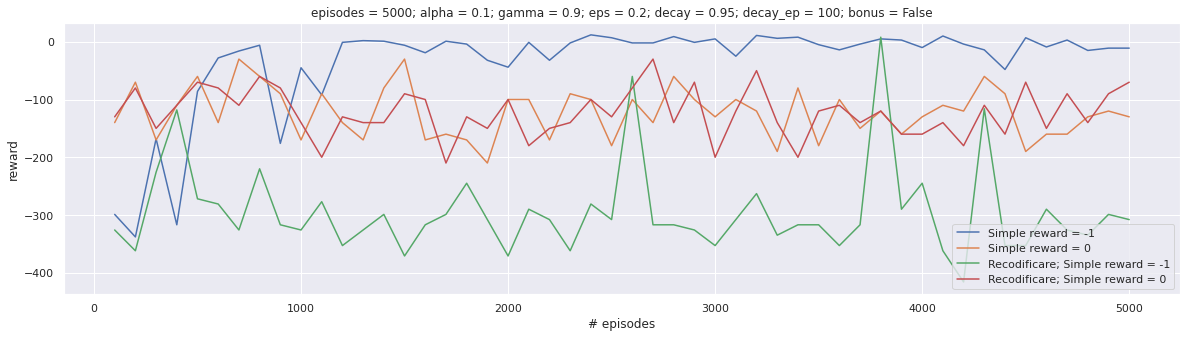

In [11]:
def plot_training(
    alg,
    env,
    num_ep: int,
    alpha: float,
    gamma: float,
    eps: float,
    decay: float,
    decay_ep: int,
    bonus: bool
):
    x_points = np.arange(LOG_INTERVAL, num_ep + 1, LOG_INTERVAL)

    print(
        f'episodes = {num_ep}; alpha = {alpha}; gamma = {gamma}; eps = {eps}; '
        f'decay = {decay}; decay_ep = {decay_ep}; bonus = {bonus}'
    )

    Q, rewards = alg(env, num_ep, alpha, gamma, eps, decay, decay_ep, False, False, bonus)
    conv = count_convergence(Q, env, False, False)
    print(f'recode = F; adjust = F; conv = {conv}%')

    Q, rewards_adjust = alg(env, num_ep, alpha, gamma, eps, decay, decay_ep, False, True, bonus)
    conv = count_convergence(Q, env, False, False)
    print(f'recode = F; adjust = T; conv = {conv}%')

    Q, rewards_recode = alg(env, num_ep, alpha, gamma, eps, decay, decay_ep, True, False, bonus)
    conv = count_convergence(Q, env, False, False)
    print(f'recode = T; adjust = F; conv = {conv}%')

    Q, rewards_recode_adjust = alg(env, num_ep, alpha, gamma, eps, decay, decay_ep, True, True, bonus)
    conv = count_convergence(Q, env, False, False)
    print(f'recode = T; adjust = T; conv = {conv}%\n')

    pyplot.figure(figsize=(20, 5))

    plt = sns.lineplot(x=x_points, y=rewards, legend='brief', label='Simple reward = -1')
    plt = sns.lineplot(x=x_points, y=rewards_adjust, legend='brief', label='Simple reward = 0')
    plt = sns.lineplot(x=x_points, y=rewards_recode, legend='brief', label='Recodificare; Simple reward = -1')
    plt = sns.lineplot(x=x_points, y=rewards_recode_adjust, legend='brief', label='Recodificare; Simple reward = 0')

    plt.set(xlabel="# episodes", ylabel="reward")
    pyplot.show()

# plot_training(q_learning, ENV, NR_EPISODES, ALPHA, GAMMA, EPSILON, DECAY_EPS, DECAY_EPS_EPISODES, BONUS)

### 4.2 SARSA (25p)
Implementați algoritmul SARSA.

Formula de update pentru `Q` este:
$$
  Q[s_t, a] = Q[s_t, a] + \alpha(R + \gamma Q[s_{t+1}, a'] - Q[s_t, a])
$$

Unde:
- $s_t$ - starea la momentul `t`
- **a** - acțiunea aleasă la momentul `t`
- **a'** - acțiunea aleasă la momentul `t+1`, presupunând ca suntem în starea $s_{t+1}$
- $\alpha$, $\gamma$ - parametru setat înainte de rulare
- $s_{t+1}$ - starea la momentul `t+1`, după ce s-a efectua acțiunea `a`

### Train

In [12]:
def sarsa(
    env,
    num_ep: int,
    alpha: float,
    gamma: float,
    eps: float,
    decay: float,
    decay_ep: int,
    recode: bool,
    adjust: bool,
    bonus: bool
) -> (np.array, [int]):
    # Table used to keep the utilities for state-action
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    env.seed(42)

    for i in range(1, num_ep + 1):
        state = reencode(env, env.reset(), recode)
        has_ended = False
        total_reward = 0

        # Get the action
        action = choose_action(env, Q, state, eps)

        while not has_ended:
            # Do the action
            next_state, reward, has_ended, _ = env.step(action)
            next_state = reencode(env, next_state, recode)
            reward = adjust_reward(reward, adjust)

            # Get the next_action from the next_state
            next_action = choose_action(env, Q, next_state, eps)

            # Cumulate the reward for plotting
            total_reward += reward

            # Update the Q(state, action) with the new value
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

            # Go to the new state
            state = next_state

            # Update the action
            action = next_action

        if i % LOG_INTERVAL == 0:
            rewards.append(total_reward)
            # print(f"Episode: {i}")

        # (BONUS): Decay eps for every DECAY_EPS_EPISODES
        # Use DECAY_EPS
        if bonus and i % decay_ep == 0:
            eps *= decay

    return Q, rewards

#### Let's check the driver

In [14]:
# test_algorithm(
#     sarsa(ENV, NR_EPISODES, ALPHA, GAMMA, EPSILON, DECAY_EPS, DECAY_EPS_EPISODES, False, False, BONUS)[0],
#     ENV, False, False
# )

20

#### And the rewards

episodes = 5000; alpha = 0.1; gamma = 0.9; eps = 0.2; decay = 0.95; decay_ep = 100; bonus = False
recode = F; adjust = F; conv = 93%
recode = F; adjust = T; conv = 92%
recode = T; adjust = F; conv = 55%
recode = T; adjust = T; conv = 63%


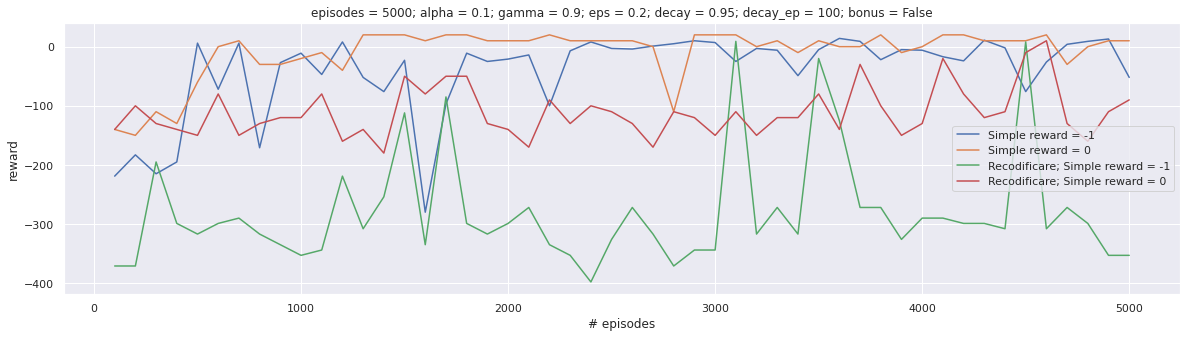

In [15]:
# plot_training(sarsa, ENV, NR_EPISODES, ALPHA, GAMMA, EPSILON, DECAY_EPS, DECAY_EPS_EPISODES, BONUS)

### 4.3 Results (35p)

Modificați parametrii algoritmilor (cele de la începutul Notebook-ului), faceți grafice pentru fiecare caz și explicați rezultatele obținute.

Unii (și nu numai) dintre paramatrii pe care îi puteți modifica:
- numărul de episoade de antrenare
- `eps` mai mic/mare
- valoarea lui $\gamma$
- valoarea lui $\alpha$

In [16]:
def test_hyperparams(
    alg,
    nums_ep: [int],
    alphas: [float],
    gammas: [float],
    epss: [float],
    decays: [float],
    decays_ep: [int],
    bonus: bool
):
    for num_ep in nums_ep:
        for alpha in alphas:
            for gamma in gammas:
                for eps in epss:
                    for decay in decays:
                        for decay_ep in decays_ep:
                            plot_training(alg, ENV, num_ep, alpha, gamma, eps, decay, decay_ep, bonus)

In [18]:
# test_hyperparams(q_learning, [NR_EPISODES], np.arange(0, 1.1, 0.1), [GAMMA], [EPSILON], [DECAY_EPS], [DECAY_EPS_EPISODES], False)

In [19]:
# test_hyperparams(q_learning, [NR_EPISODES], [ALPHA], np.arange(0, 1.1, 0.1), [EPSILON], [DECAY_EPS], [DECAY_EPS_EPISODES], False)

In [20]:
# test_hyperparams(q_learning, [NR_EPISODES], [ALPHA], [GAMMA], np.arange(0, 1.1, 0.1), [DECAY_EPS], [DECAY_EPS_EPISODES], False)

In [21]:
# test_hyperparams(q_learning, [NR_EPISODES], [ALPHA], [GAMMA], [EPSILON], [DECAY_EPS], range(100, 1100, 100), True)

In [22]:
# test_hyperparams(sarsa, range(0, 11000, 1000), [ALPHA], [GAMMA], [EPSILON], [DECAY_EPS], [DECAY_EPS_EPISODES], False)

In [23]:
# test_hyperparams(sarsa, [NR_EPISODES], np.arange(0, 1.1, 0.1), [GAMMA], [EPSILON], [DECAY_EPS], [DECAY_EPS_EPISODES], False)

In [24]:
# test_hyperparams(sarsa, [NR_EPISODES], [ALPHA], [GAMMA], np.arange(0, 1.1, 0.1), [DECAY_EPS], [DECAY_EPS_EPISODES], False)

In [25]:
# test_hyperparams(sarsa, [NR_EPISODES], [ALPHA], [GAMMA], [EPSILON], np.arange(0, 1.1, 0.01), [DECAY_EPS_EPISODES], True)

In [26]:
# test_hyperparams(sarsa, [NR_EPISODES], [ALPHA], [GAMMA], [EPSILON], [DECAY_EPS], range(100, 1100, 100), True)

#### 4.4 And something more... (10p)
##### A simple move (5p)
Dorim să vedem importanța reward-ului și a stării.

Modificați celula de antrenare pentru una dintre metode astfel încât reward-ul pentru o **mutare simplă** să fie 0, (acum este -1). Refaceți graficul metodei alese și trageți concluziile.

##### A little less space (5p)
**Starea** are valori discrete (500 de valori posibile), iar aceasta este encodată folosind metoda d [aici](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py#L128).

Rescrieți codul astfel încât starea să fie encodată folosind:
$$
(((taxi\_row * 5) + taxi\_column) * 5 + pass\_loc) * 2 + destination
$$
Antrenați unul dintre algoritmi, faceți graficul și explicați rezultatul.

**Atenție!** Trebuie să și modificați cum arată Q (forma matricei).

Hint: Decodarea stării este [aici](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py#L139)

## 5 BONUS: Some decay on the way (10p)
Analizați ce se întâmplă daca scadeți treptat `eps`, pe măsura antrenării. 

Intuitiv, dorim ca la începutul antrenării agentul să **exploreze** cât mai mult posibil și să atingă un număr mare de stări (în exemplul nostru cu taxiul, nu avem așa multe stări, dar sunt jocuri în care spațiul stărilor poate fi mai mare).

De asemenea, pe măsură ce continuăm antrenarea, dorim ca taximetristul să înceapă să **exploateze** mai mult stările cunoscute cu o utilitate mare.